# 🎯 Xception: Deep Learning with Depthwise Separable Convolutions

## Part 2: Inception Evolution, Xception Architecture & Model Inference

---

**👨‍🎓 Sunan:** Çağatay ÜRESİN  
**📅 Tarih:** 17 Aralık 2025  
**📧 GitHub:** [@cagatayuresin](https://github.com/cagatayuresin)

---

### 📖 Bu Part'ta Neler Var?

1. **Inception Hipotezi:** Cross-channel vs Spatial correlations
2. **Inception Modül Evrimi:** Canonical → Simplified → Extreme
3. **Xception Mimarisi:** Entry/Middle/Exit Flow detayları
4. **Pre-trained Model:** Gerçek inference ve tahminler
5. **Grad-CAM:** Model neye bakıyor?
6. **Feature Map Analizi:** İç katmanlar görselleştirme

---

## 📦 Kütüphaneleri İçe Aktarma

Part 1'deki tüm import'lar + ek görselleştirme araçları

In [1]:
# Temel kütüphaneler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle, FancyBboxPatch, FancyArrowPatch, Circle
from matplotlib.patches import ConnectionPatch
import seaborn as sns
from PIL import Image
import io
import requests
from IPython.display import display, HTML, clear_output
import warnings
warnings.filterwarnings('ignore')

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess

# PyTorch
import torch
import torch.nn as nn

# Plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# OpenCV
import cv2

# Widget'lar
from ipywidgets import interact, interactive, widgets
import ipywidgets as widgets

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Kütüphaneler yüklendi!")
print(f"🔧 TensorFlow: {tf.__version__}")
print(f"🔧 PyTorch: {torch.__version__}")

✅ Kütüphaneler yüklendi!
🔧 TensorFlow: 2.19.0
🔧 PyTorch: 2.9.0+cpu


---

# 🧠 BÖLÜM 1: Inception Hipotezi ve Modül Evrimi

## 1.1 Temel Hipotez

### 🎯 Inception'ın Ana Fikri:

> **"Cross-channel correlations ve spatial correlations yeterince bağımsızdır ki onları ayrı ayrı öğrenebiliriz!"**

### Standard Convolution:
```
Input (H×W×C_in) → [3D Convolution] → Output (H×W×C_out)
                    ↓
          Spatial + Channel correlations
          AYNI ANDA öğrenilir
```

### Inception Yaklaşımı:
```
Input → [1×1 Conv] → [3×3 Conv] → Output
         ↓             ↓
      Channel       Spatial
      mixing      correlations
```

---

## 1.2 Inception Modül Çeşitleri

### Evrim:

```
Canonical Inception (V3)
        ↓
Simplified Inception (tek tower)
        ↓
Reformulated (equivalence gösterimi)
        ↓
Extreme Inception = Depthwise Separable Conv!
```

Şimdi bu evrimi görselleştirelim...

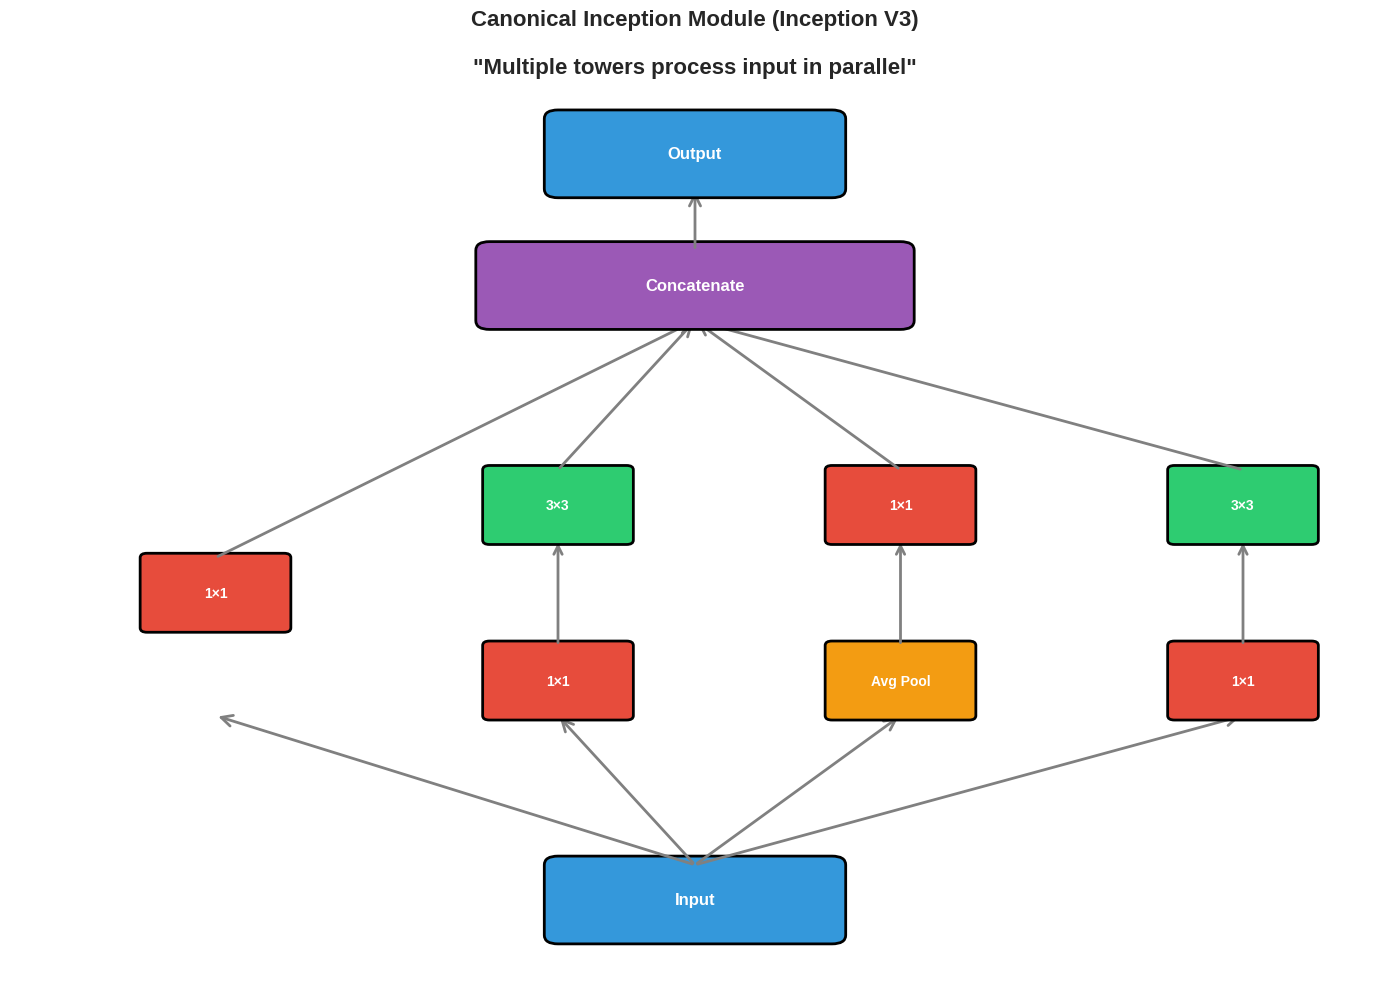

In [2]:
def draw_inception_canonical():
    """
    Canonical Inception Module (Makale Figure 1) çizimi
    """
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')

    # Renkler
    color_input = '#3498db'
    color_1x1 = '#e74c3c'
    color_3x3 = '#2ecc71'
    color_pool = '#f39c12'
    color_concat = '#9b59b6'

    # Input
    input_box = FancyBboxPatch((4, 0.5), 2, 0.8,
                               boxstyle="round,pad=0.1",
                               facecolor=color_input,
                               edgecolor='black', linewidth=2)
    ax.add_patch(input_box)
    ax.text(5, 0.9, 'Input', ha='center', va='center',
            fontsize=12, fontweight='bold', color='white')

    # Tower positions
    tower_x = [1, 3.5, 6, 8.5]
    tower_labels = ['1×1', '1×1→3×3', 'Avg Pool→1×1', '1×1→3×3']
    tower_colors = [color_1x1, color_3x3, color_pool, color_3x3]

    # Draw towers
    for i, (x, label, color) in enumerate(zip(tower_x, tower_labels, tower_colors)):
        # Arrow from input
        arrow = FancyArrowPatch((5, 1.3), (x+0.5, 3),
                               arrowstyle='->', mutation_scale=20,
                               linewidth=2, color='gray')
        ax.add_patch(arrow)

        if '→' in label:
            # Two-stage tower
            parts = label.split('→')

            # First stage
            box1 = FancyBboxPatch((x, 3), 1, 0.8,
                                 boxstyle="round,pad=0.05",
                                 facecolor=color_1x1 if parts[0] != 'Avg Pool' else color_pool,
                                 edgecolor='black', linewidth=2)
            ax.add_patch(box1)
            ax.text(x+0.5, 3.4, parts[0], ha='center', va='center',
                   fontsize=10, fontweight='bold', color='white')

            # Arrow between stages
            arrow2 = FancyArrowPatch((x+0.5, 3.8), (x+0.5, 5),
                                    arrowstyle='->', mutation_scale=15,
                                    linewidth=2, color='gray')
            ax.add_patch(arrow2)

            # Second stage
            box2 = FancyBboxPatch((x, 5), 1, 0.8,
                                 boxstyle="round,pad=0.05",
                                 facecolor=color if 'Pool' not in parts[0] else color_1x1,
                                 edgecolor='black', linewidth=2)
            ax.add_patch(box2)
            ax.text(x+0.5, 5.4, parts[1], ha='center', va='center',
                   fontsize=10, fontweight='bold', color='white')

            # Arrow to concat
            arrow3 = FancyArrowPatch((x+0.5, 5.8), (5, 7.5),
                                    arrowstyle='->', mutation_scale=20,
                                    linewidth=2, color='gray')
            ax.add_patch(arrow3)
        else:
            # Single stage tower
            box = FancyBboxPatch((x, 4), 1, 0.8,
                                boxstyle="round,pad=0.05",
                                facecolor=color,
                                edgecolor='black', linewidth=2)
            ax.add_patch(box)
            ax.text(x+0.5, 4.4, label, ha='center', va='center',
                   fontsize=10, fontweight='bold', color='white')

            # Arrow to concat
            arrow3 = FancyArrowPatch((x+0.5, 4.8), (5, 7.5),
                                    arrowstyle='->', mutation_scale=20,
                                    linewidth=2, color='gray')
            ax.add_patch(arrow3)

    # Concatenation
    concat_box = FancyBboxPatch((3.5, 7.5), 3, 0.8,
                                boxstyle="round,pad=0.1",
                                facecolor=color_concat,
                                edgecolor='black', linewidth=2)
    ax.add_patch(concat_box)
    ax.text(5, 7.9, 'Concatenate', ha='center', va='center',
           fontsize=12, fontweight='bold', color='white')

    # Output
    arrow_out = FancyArrowPatch((5, 8.3), (5, 9),
                               arrowstyle='->', mutation_scale=20,
                               linewidth=2, color='gray')
    ax.add_patch(arrow_out)

    output_box = FancyBboxPatch((4, 9), 2, 0.8,
                                boxstyle="round,pad=0.1",
                                facecolor=color_input,
                                edgecolor='black', linewidth=2)
    ax.add_patch(output_box)
    ax.text(5, 9.4, 'Output', ha='center', va='center',
           fontsize=12, fontweight='bold', color='white')

    plt.title('Canonical Inception Module (Inception V3)\n\n"Multiple towers process input in parallel"',
             fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

# Çiz
draw_inception_canonical()

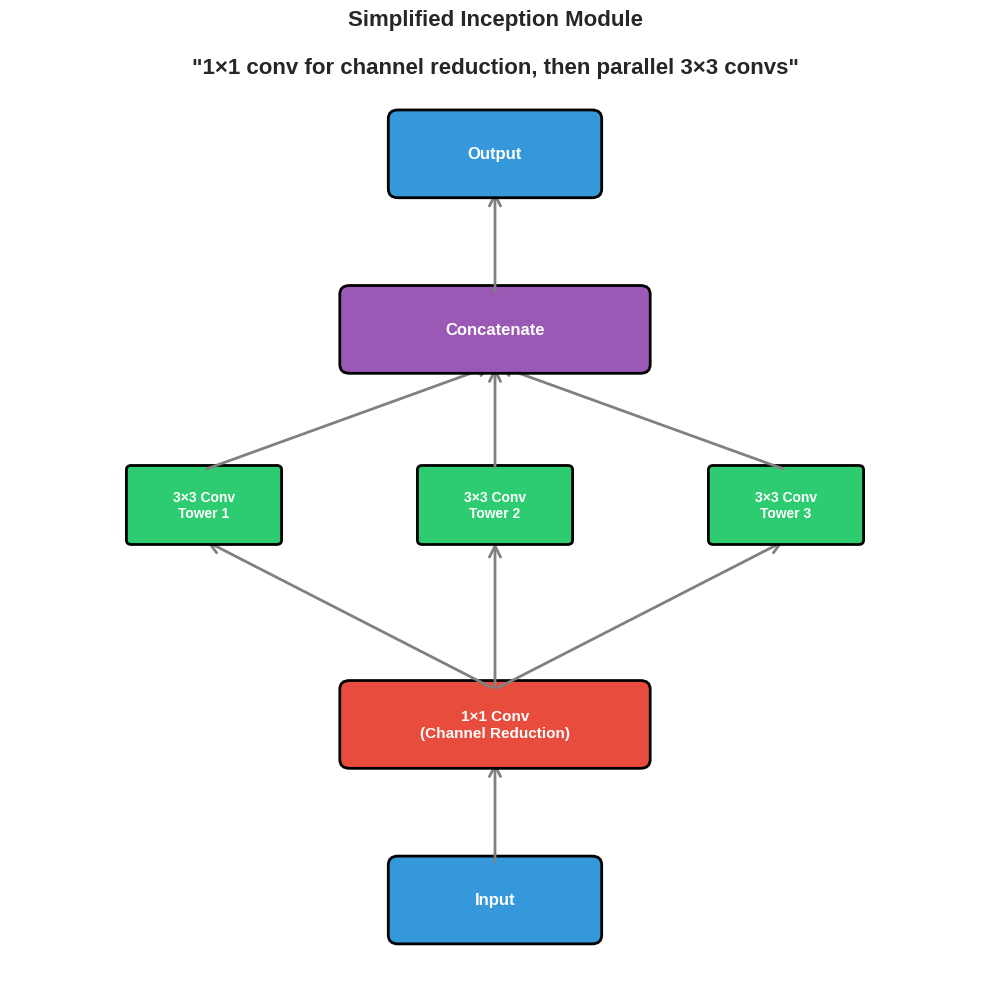

In [3]:
def draw_inception_simplified():
    """
    Simplified Inception Module (Makale Figure 2)
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')

    color_input = '#3498db'
    color_1x1 = '#e74c3c'
    color_3x3 = '#2ecc71'
    color_concat = '#9b59b6'

    # Input
    input_box = FancyBboxPatch((4, 0.5), 2, 0.8,
                               boxstyle="round,pad=0.1",
                               facecolor=color_input,
                               edgecolor='black', linewidth=2)
    ax.add_patch(input_box)
    ax.text(5, 0.9, 'Input', ha='center', va='center',
           fontsize=12, fontweight='bold', color='white')

    # 1x1 Conv (channel reduction)
    arrow1 = FancyArrowPatch((5, 1.3), (5, 2.5),
                            arrowstyle='->', mutation_scale=20,
                            linewidth=2, color='gray')
    ax.add_patch(arrow1)

    conv1x1_box = FancyBboxPatch((3.5, 2.5), 3, 0.8,
                                 boxstyle="round,pad=0.1",
                                 facecolor=color_1x1,
                                 edgecolor='black', linewidth=2)
    ax.add_patch(conv1x1_box)
    ax.text(5, 2.9, '1×1 Conv\n(Channel Reduction)', ha='center', va='center',
           fontsize=11, fontweight='bold', color='white')

    # Three parallel 3x3 convs
    tower_x = [2, 5, 8]
    for i, x in enumerate(tower_x):
        # Arrow from 1x1
        arrow = FancyArrowPatch((5, 3.3), (x, 5),
                               arrowstyle='->', mutation_scale=20,
                               linewidth=2, color='gray')
        ax.add_patch(arrow)

        # 3x3 conv
        conv3x3_box = FancyBboxPatch((x-0.75, 5), 1.5, 0.8,
                                     boxstyle="round,pad=0.05",
                                     facecolor=color_3x3,
                                     edgecolor='black', linewidth=2)
        ax.add_patch(conv3x3_box)
        ax.text(x, 5.4, f'3×3 Conv\nTower {i+1}', ha='center', va='center',
               fontsize=10, fontweight='bold', color='white')

        # Arrow to concat
        arrow2 = FancyArrowPatch((x, 5.8), (5, 7),
                                arrowstyle='->', mutation_scale=20,
                                linewidth=2, color='gray')
        ax.add_patch(arrow2)

    # Concatenation
    concat_box = FancyBboxPatch((3.5, 7), 3, 0.8,
                                boxstyle="round,pad=0.1",
                                facecolor=color_concat,
                                edgecolor='black', linewidth=2)
    ax.add_patch(concat_box)
    ax.text(5, 7.4, 'Concatenate', ha='center', va='center',
           fontsize=12, fontweight='bold', color='white')

    # Output
    arrow_out = FancyArrowPatch((5, 7.8), (5, 9),
                               arrowstyle='->', mutation_scale=20,
                               linewidth=2, color='gray')
    ax.add_patch(arrow_out)

    output_box = FancyBboxPatch((4, 9), 2, 0.8,
                                boxstyle="round,pad=0.1",
                                facecolor=color_input,
                                edgecolor='black', linewidth=2)
    ax.add_patch(output_box)
    ax.text(5, 9.4, 'Output', ha='center', va='center',
           fontsize=12, fontweight='bold', color='white')

    plt.title('Simplified Inception Module\n\n"1×1 conv for channel reduction, then parallel 3×3 convs"',
             fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

draw_inception_simplified()

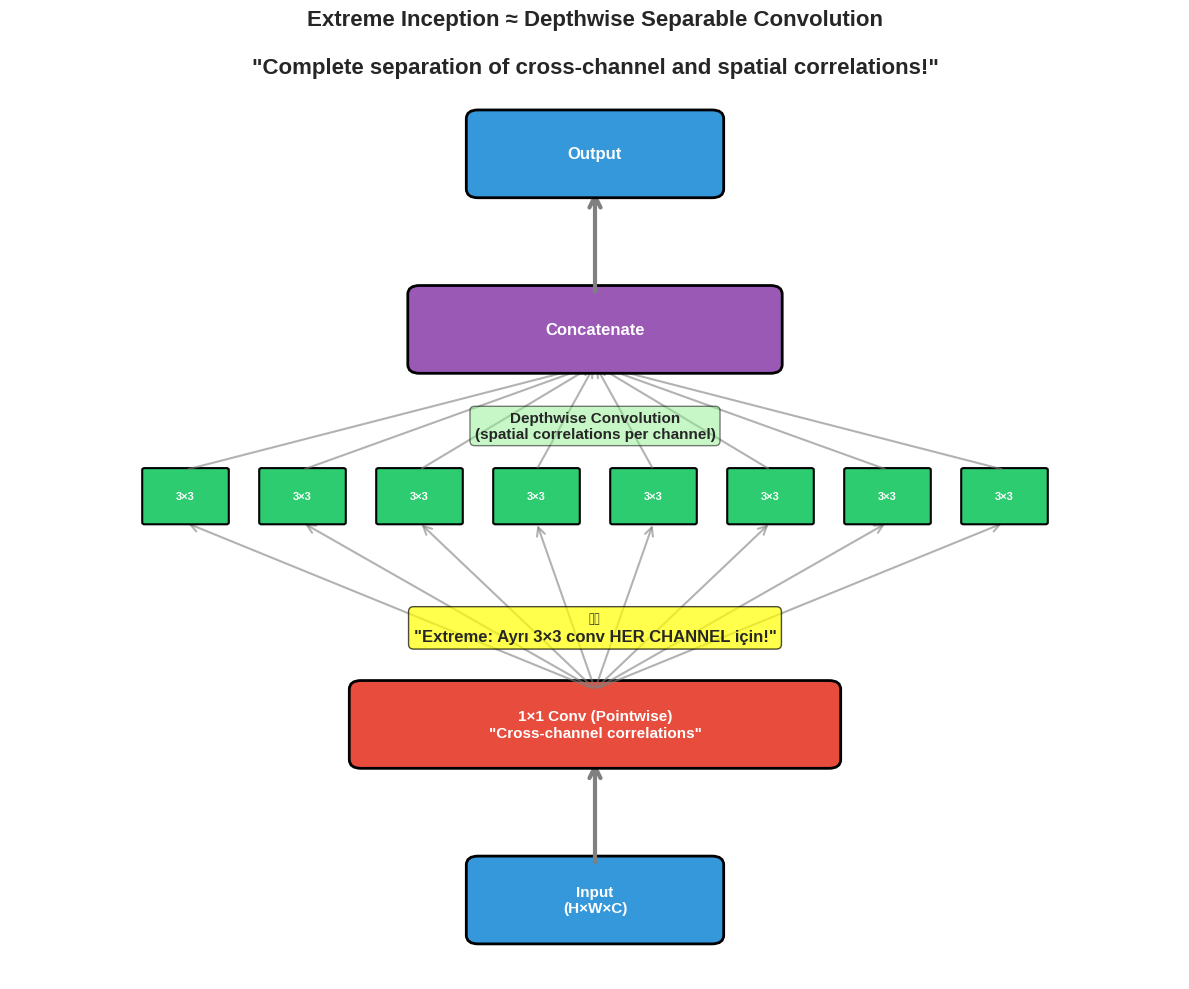

In [4]:
def draw_inception_extreme():
    """
    Extreme Inception = Depthwise Separable Conv (Makale Figure 4)
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')

    color_input = '#3498db'
    color_1x1 = '#e74c3c'
    color_3x3 = '#2ecc71'
    color_concat = '#9b59b6'

    # Input
    input_box = FancyBboxPatch((4, 0.5), 2, 0.8,
                               boxstyle="round,pad=0.1",
                               facecolor=color_input,
                               edgecolor='black', linewidth=2)
    ax.add_patch(input_box)
    ax.text(5, 0.9, 'Input\n(H×W×C)', ha='center', va='center',
           fontsize=11, fontweight='bold', color='white')

    # 1x1 Conv (pointwise)
    arrow1 = FancyArrowPatch((5, 1.3), (5, 2.5),
                            arrowstyle='->', mutation_scale=20,
                            linewidth=3, color='gray')
    ax.add_patch(arrow1)

    conv1x1_box = FancyBboxPatch((3, 2.5), 4, 0.8,
                                 boxstyle="round,pad=0.1",
                                 facecolor=color_1x1,
                                 edgecolor='black', linewidth=2)
    ax.add_patch(conv1x1_box)
    ax.text(5, 2.9, '1×1 Conv (Pointwise)\n"Cross-channel correlations"',
           ha='center', va='center',
           fontsize=11, fontweight='bold', color='white')

    # Text: "Extreme version - one 3x3 per channel!"
    ax.text(5, 4, '⬇️\n"Extreme: Ayrı 3×3 conv HER CHANNEL için!"',
           ha='center', va='center', fontsize=12, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

    # Many parallel 3x3 convs (depthwise)
    num_channels = 8  # Örnek olarak 8 channel göster
    start_x = 1.5
    spacing = 1

    for i in range(num_channels):
        x = start_x + i * spacing

        # Arrow
        arrow = FancyArrowPatch((5, 3.3), (x, 5.2),
                               arrowstyle='->', mutation_scale=15,
                               linewidth=1.5, color='gray', alpha=0.6)
        ax.add_patch(arrow)

        # Small 3x3 box
        conv_box = FancyBboxPatch((x-0.35, 5.2), 0.7, 0.6,
                                 boxstyle="round,pad=0.02",
                                 facecolor=color_3x3,
                                 edgecolor='black', linewidth=1.5)
        ax.add_patch(conv_box)
        ax.text(x, 5.5, '3×3', ha='center', va='center',
               fontsize=8, fontweight='bold', color='white')

        # Arrow to concat
        arrow2 = FancyArrowPatch((x, 5.8), (5, 7),
                                arrowstyle='->', mutation_scale=15,
                                linewidth=1.5, color='gray', alpha=0.6)
        ax.add_patch(arrow2)

    # Label for depthwise
    ax.text(5, 6.3, 'Depthwise Convolution\n(spatial correlations per channel)',
           ha='center', va='center', fontsize=11, fontweight='bold',
           bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

    # Concatenation
    concat_box = FancyBboxPatch((3.5, 7), 3, 0.8,
                                boxstyle="round,pad=0.1",
                                facecolor=color_concat,
                                edgecolor='black', linewidth=2)
    ax.add_patch(concat_box)
    ax.text(5, 7.4, 'Concatenate', ha='center', va='center',
           fontsize=12, fontweight='bold', color='white')

    # Output
    arrow_out = FancyArrowPatch((5, 7.8), (5, 9),
                               arrowstyle='->', mutation_scale=20,
                               linewidth=3, color='gray')
    ax.add_patch(arrow_out)

    output_box = FancyBboxPatch((4, 9), 2, 0.8,
                                boxstyle="round,pad=0.1",
                                facecolor=color_input,
                                edgecolor='black', linewidth=2)
    ax.add_patch(output_box)
    ax.text(5, 9.4, 'Output', ha='center', va='center',
           fontsize=12, fontweight='bold', color='white')

    plt.title('Extreme Inception ≈ Depthwise Separable Convolution\n\n"Complete separation of cross-channel and spatial correlations!"',
             fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

draw_inception_extreme()

## 1.3 Continuum: Regular Conv ↔ Depthwise Separable Conv

Inception modülleri bu iki uç arasında bir spektrum oluşturur:

```
Regular Conv          Inception Modules        Depthwise Separable
(1 segment)           (3-4 segments)           (C segments)
     ↓                       ↓                         ↓
All channels          Few groups of            One conv per
processed             channels processed       channel
together              separately
```

### Parametre Sayısı Spektrumu:

In [5]:
def visualize_conv_spectrum():
    """
    Regular Conv → Inception → Separable Conv spektrumunu görselleştir
    """
    # Parametre hesaplama
    k = 3  # kernel size
    cin = 256
    cout = 256

    # Farklı segment sayıları için parametre hesapla
    num_segments = [1, 2, 4, 8, 16, 32, 64, 128, 256]  # 1=regular, 256=separable
    params = []

    for n in num_segments:
        if n == 1:
            # Regular conv
            p = k * k * cin * cout
        elif n == cin:
            # Depthwise separable
            p = k * k * cin + cin * cout
        else:
            # Intermediate: grouped convolution
            # Her grup: k*k*(cin/n)*(cout/n)
            # n grup: n * k*k*(cin/n)*(cout/n) = k*k*cin*cout/n
            p = k * k * cin * cout // n + cin * cout  # Approximation

        params.append(p)

    # Plotly ile interaktif grafik
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=num_segments,
        y=params,
        mode='lines+markers',
        name='Parametre Sayısı',
        line=dict(color='#e74c3c', width=3),
        marker=dict(size=10, color='#c0392b'),
        hovertemplate='Segments: %{x}<br>Params: %{y:,}<extra></extra>'
    ))

    # Special points
    special_x = [1, 4, 256]
    special_y = [params[0], params[2], params[-1]]
    special_labels = ['Regular Conv', 'Inception-like<br>(4 segments)', 'Depthwise Separable']

    for x, y, label in zip(special_x, special_y, special_labels):
        fig.add_trace(go.Scatter(
            x=[x],
            y=[y],
            mode='markers+text',
            marker=dict(size=15, color='yellow', line=dict(width=2, color='black')),
            text=[label],
            textposition='top center',
            textfont=dict(size=12, color='black', family='Arial Black'),
            showlegend=False,
            hovertemplate=f'{label}<br>Params: {y:,}<extra></extra>'
        ))

    fig.update_layout(
        title=dict(
            text='Convolution Spectrum: Regular → Inception → Separable<br><sub>Parametre sayısı segment sayısına göre</sub>',
            x=0.5,
            xanchor='center',
            font=dict(size=18, color='black', family='Arial Black')
        ),
        xaxis=dict(
            title='Number of Segments (Channel Groups)',
            type='log',
            gridcolor='lightgray'
        ),
        yaxis=dict(
            title='Number of Parameters',
            gridcolor='lightgray'
        ),
        hovermode='x unified',
        plot_bgcolor='white',
        width=1000,
        height=600
    )

    fig.show()

    # İstatistikler
    print("\n" + "="*70)
    print("📊 SPEKTRUM İSTATİSTİKLERİ")
    print("="*70)
    print(f"\n🔴 Regular Conv (1 segment):")
    print(f"   └─ {params[0]:,} parametreler")
    print(f"\n🟡 Inception-like (4 segments):")
    print(f"   └─ {params[2]:,} parametreler ({(1-params[2]/params[0])*100:.1f}% azalma)")
    print(f"\n🟢 Depthwise Separable (256 segments):")
    print(f"   └─ {params[-1]:,} parametreler ({(1-params[-1]/params[0])*100:.1f}% azalma)")
    print("="*70)

visualize_conv_spectrum()


📊 SPEKTRUM İSTATİSTİKLERİ

🔴 Regular Conv (1 segment):
   └─ 589,824 parametreler

🟡 Inception-like (4 segments):
   └─ 212,992 parametreler (63.9% azalma)

🟢 Depthwise Separable (256 segments):
   └─ 67,840 parametreler (88.5% azalma)


---

# 🏗️ BÖLÜM 2: Xception Mimarisi

## 2.1 Xception = "Extreme Inception"

### Ana Fikir:
> Tüm Inception modüllerini **Depthwise Separable Convolution** ile değiştir!

### Mimari Bileşenleri:

```
┌─────────────┐
│ Entry Flow  │  ← Initial feature extraction (aggressive downsampling)
└──────┬──────┘
       ↓
┌─────────────┐
│Middle Flow  │  ← Repeated 8 times (deep feature learning)
└──────┬──────┘
       ↓
┌─────────────┐
│ Exit Flow   │  ← Final processing before classification
└──────┬──────┘
       ↓
  [Classifier]
```

### Toplam:
- **36 convolutional layers**
- **14 modules** (residual connections ile)
- **~23M parameters**

---

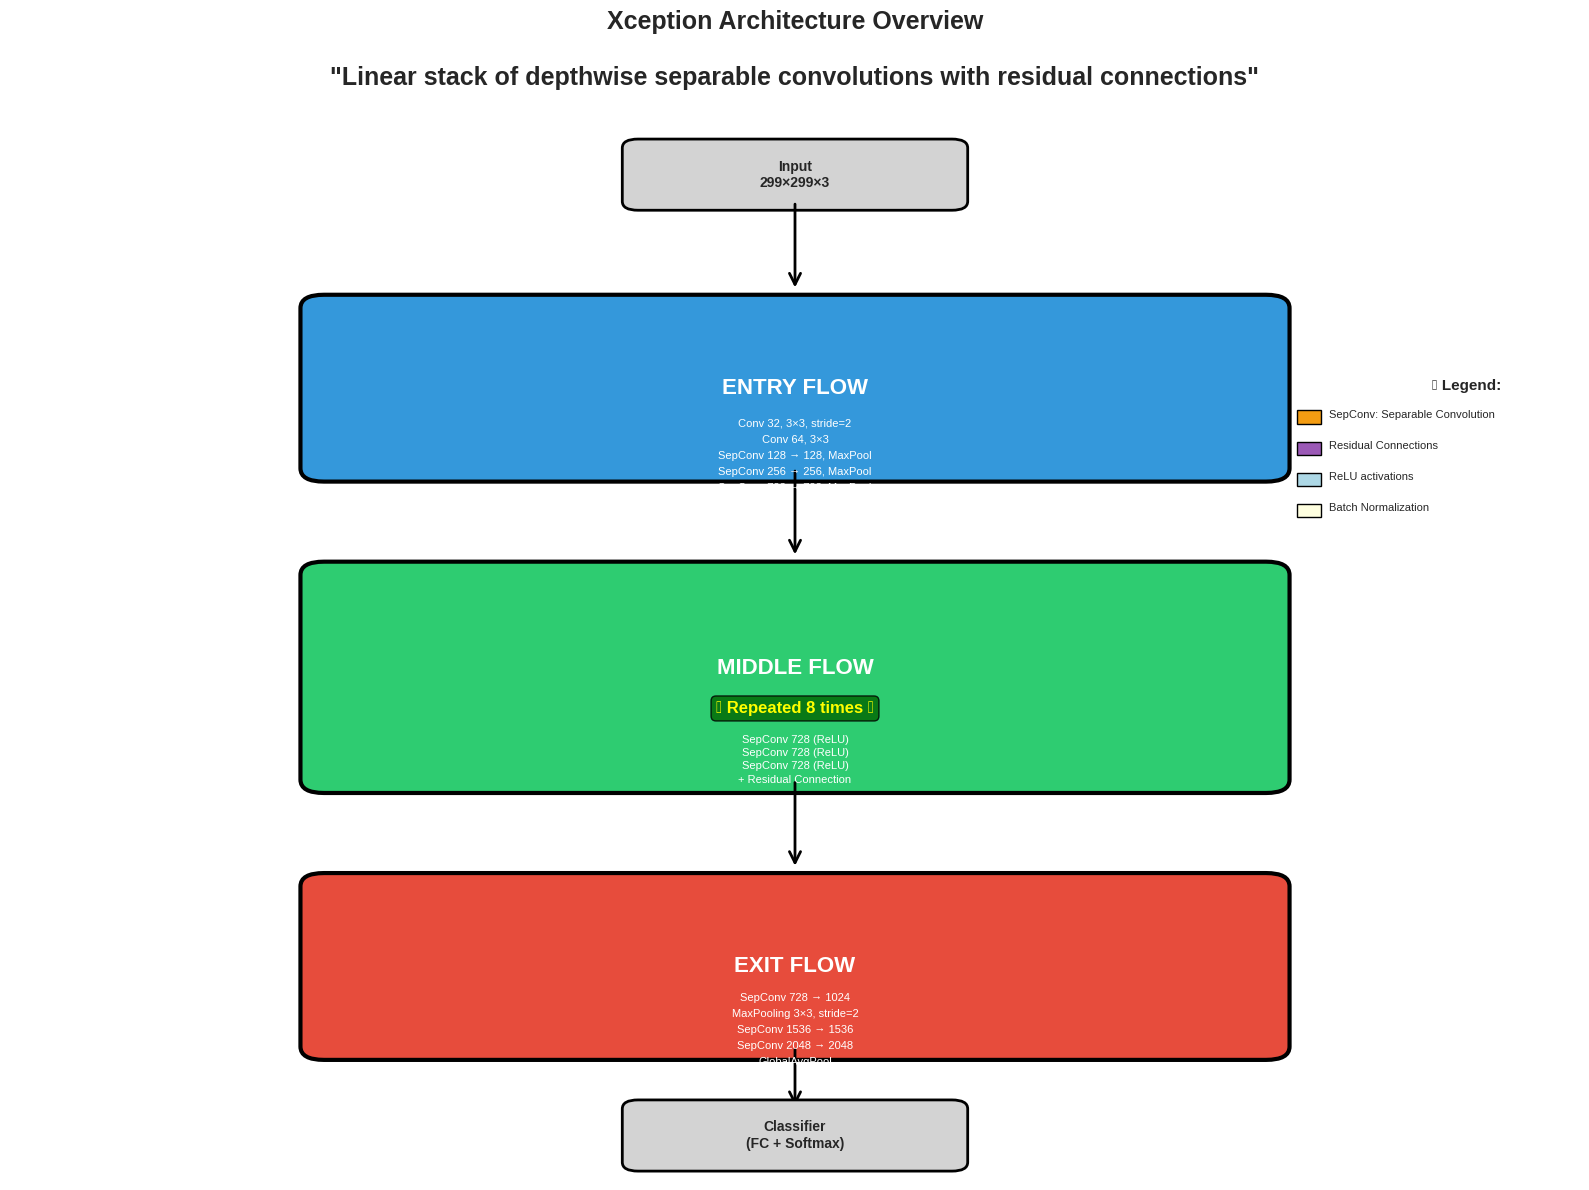

In [6]:
def draw_xception_architecture():
    """
    Xception mimarisinin yüksek seviye diyagramı
    """
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 12)
    ax.axis('off')

    # Renkler
    color_entry = '#3498db'
    color_middle = '#2ecc71'
    color_exit = '#e74c3c'
    color_sep_conv = '#f39c12'
    color_residual = '#9b59b6'

    y_pos = 11

    # Input
    input_box = FancyBboxPatch((4, y_pos), 2, 0.6,
                               boxstyle="round,pad=0.1",
                               facecolor='lightgray',
                               edgecolor='black', linewidth=2)
    ax.add_patch(input_box)
    ax.text(5, y_pos+0.3, 'Input\n299×299×3', ha='center', va='center',
           fontsize=10, fontweight='bold')

    y_pos -= 1

    # Entry Flow
    arrow = FancyArrowPatch((5, y_pos+1), (5, y_pos),
                           arrowstyle='->', mutation_scale=20,
                           linewidth=2, color='black')
    ax.add_patch(arrow)

    entry_box = FancyBboxPatch((2, y_pos-2), 6, 1.8,
                               boxstyle="round,pad=0.15",
                               facecolor=color_entry,
                               edgecolor='black', linewidth=3)
    ax.add_patch(entry_box)
    ax.text(5, y_pos-1.1, 'ENTRY FLOW', ha='center', va='center',
           fontsize=16, fontweight='bold', color='white')

    # Entry flow details
    entry_details = [
        'Conv 32, 3×3, stride=2',
        'Conv 64, 3×3',
        'SepConv 128 → 128, MaxPool',
        'SepConv 256 → 256, MaxPool',
        'SepConv 728 → 728, MaxPool'
    ]
    for i, detail in enumerate(entry_details):
        ax.text(5, y_pos-1.5 - i*0.18, detail, ha='center', va='center',
               fontsize=8, color='white')

    y_pos -= 3

    # Middle Flow
    arrow = FancyArrowPatch((5, y_pos+1), (5, y_pos),
                           arrowstyle='->', mutation_scale=20,
                           linewidth=2, color='black')
    ax.add_patch(arrow)

    middle_box = FancyBboxPatch((2, y_pos-2.5), 6, 2.3,
                                boxstyle="round,pad=0.15",
                                facecolor=color_middle,
                                edgecolor='black', linewidth=3)
    ax.add_patch(middle_box)
    ax.text(5, y_pos-1.25, 'MIDDLE FLOW', ha='center', va='center',
           fontsize=16, fontweight='bold', color='white')

    # Repeated block
    ax.text(5, y_pos-1.7, '🔁 Repeated 8 times 🔁', ha='center', va='center',
           fontsize=12, fontweight='bold', color='yellow',
           bbox=dict(boxstyle='round', facecolor='darkgreen', alpha=0.8))

    middle_details = [
        'SepConv 728 (ReLU)',
        'SepConv 728 (ReLU)',
        'SepConv 728 (ReLU)',
        '+ Residual Connection'
    ]
    for i, detail in enumerate(middle_details):
        ax.text(5, y_pos-2.05 - i*0.15, detail, ha='center', va='center',
               fontsize=8, color='white')

    y_pos -= 3.5

    # Exit Flow
    arrow = FancyArrowPatch((5, y_pos+1), (5, y_pos),
                           arrowstyle='->', mutation_scale=20,
                           linewidth=2, color='black')
    ax.add_patch(arrow)

    exit_box = FancyBboxPatch((2, y_pos-2), 6, 1.8,
                              boxstyle="round,pad=0.15",
                              facecolor=color_exit,
                              edgecolor='black', linewidth=3)
    ax.add_patch(exit_box)
    ax.text(5, y_pos-1.1, 'EXIT FLOW', ha='center', va='center',
           fontsize=16, fontweight='bold', color='white')

    exit_details = [
        'SepConv 728 → 1024',
        'MaxPooling 3×3, stride=2',
        'SepConv 1536 → 1536',
        'SepConv 2048 → 2048',
        'GlobalAvgPool'
    ]
    for i, detail in enumerate(exit_details):
        ax.text(5, y_pos-1.45 - i*0.18, detail, ha='center', va='center',
               fontsize=8, color='white')

    y_pos -= 2.5

    # Output
    arrow = FancyArrowPatch((5, y_pos+0.5), (5, y_pos-0.2),
                           arrowstyle='->', mutation_scale=20,
                           linewidth=2, color='black')
    ax.add_patch(arrow)

    output_box = FancyBboxPatch((4, y_pos-0.8), 2, 0.6,
                                boxstyle="round,pad=0.1",
                                facecolor='lightgray',
                                edgecolor='black', linewidth=2)
    ax.add_patch(output_box)
    ax.text(5, y_pos-0.5, 'Classifier\n(FC + Softmax)', ha='center', va='center',
           fontsize=10, fontweight='bold')

    # Legend on the right
    legend_y = 9
    ax.text(9.5, legend_y, '📝 Legend:', ha='right', va='top',
           fontsize=11, fontweight='bold')

    legend_items = [
        (color_sep_conv, 'SepConv: Separable Convolution'),
        (color_residual, 'Residual Connections'),
        ('lightblue', 'ReLU activations'),
        ('lightyellow', 'Batch Normalization')
    ]

    for i, (color, text) in enumerate(legend_items):
        y = legend_y - 0.4 - i*0.35
        rect = Rectangle((8.2, y-0.1), 0.15, 0.15, facecolor=color, edgecolor='black')
        ax.add_patch(rect)
        ax.text(8.4, y, text, ha='left', va='center', fontsize=8)

    plt.title('Xception Architecture Overview\n\n"Linear stack of depthwise separable convolutions with residual connections"',
             fontsize=18, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

draw_xception_architecture()

## 2.2 Xception vs Inception V3 Karşılaştırması

İki mimariyi yan yana karşılaştıralım:

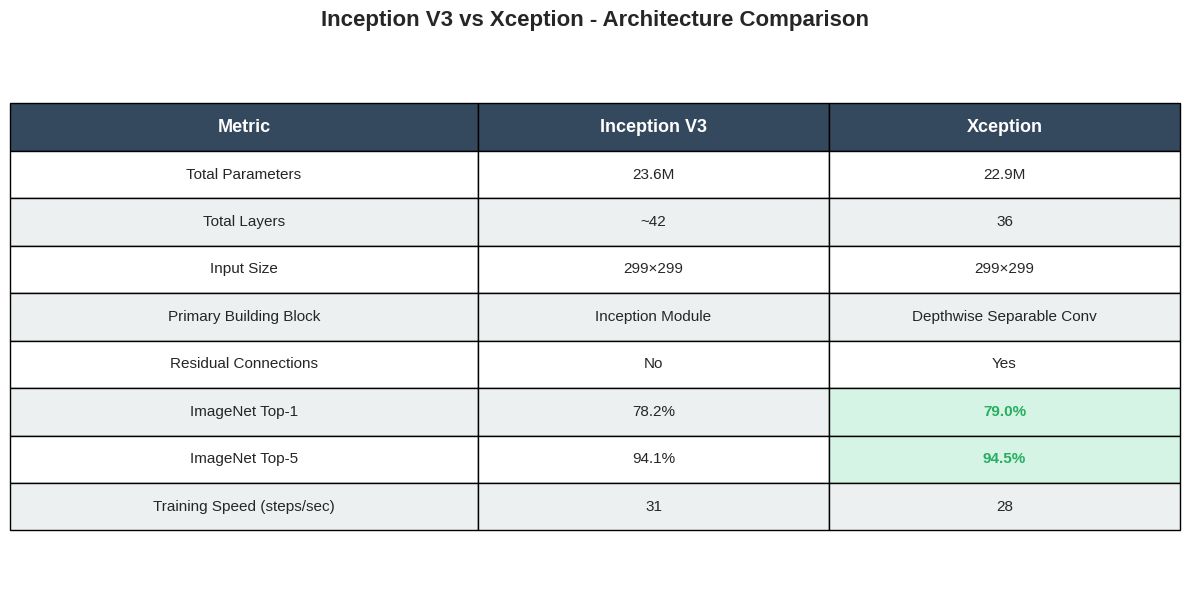


💡 Key Takeaways:
✅ Xception has FEWER parameters but BETTER performance!
✅ Simpler architecture (depthwise separable convolutions)
✅ Residual connections help convergence
✅ Slightly slower training (but not significantly)


In [7]:
# Model bilgilerini karşılaştır
comparison_data = {
    'Metric': [
        'Total Parameters',
        'Total Layers',
        'Input Size',
        'Primary Building Block',
        'Residual Connections',
        'ImageNet Top-1',
        'ImageNet Top-5',
        'Training Speed (steps/sec)'
    ],
    'Inception V3': [
        '23.6M',
        '~42',
        '299×299',
        'Inception Module',
        'No',
        '78.2%',
        '94.1%',
        '31'
    ],
    'Xception': [
        '22.9M',
        '36',
        '299×299',
        'Depthwise Separable Conv',
        'Yes',
        '79.0%',
        '94.5%',
        '28'
    ]
}

# DataFrame oluştur ve göster
import pandas as pd

df = pd.DataFrame(comparison_data)

# Styled table
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

# Create table
table = ax.table(cellText=df.values, colLabels=df.columns,
                cellLoc='center', loc='center',
                colWidths=[0.4, 0.3, 0.3])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Header styling
for i in range(3):
    cell = table[(0, i)]
    cell.set_facecolor('#34495e')
    cell.set_text_props(weight='bold', color='white', fontsize=13)

# Row colors
for i in range(1, len(df) + 1):
    for j in range(3):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#ecf0f1')
        else:
            cell.set_facecolor('white')

        # Highlight better values
        if j > 0 and i in [6, 7]:  # Accuracy rows
            if j == 2:  # Xception column
                cell.set_facecolor('#d5f4e6')
                cell.set_text_props(weight='bold', color='#27ae60')

plt.title('Inception V3 vs Xception - Architecture Comparison',
         fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n💡 Key Takeaways:")
print("="*60)
print("✅ Xception has FEWER parameters but BETTER performance!")
print("✅ Simpler architecture (depthwise separable convolutions)")
print("✅ Residual connections help convergence")
print("✅ Slightly slower training (but not significantly)")
print("="*60)

---

# 🔥 BÖLÜM 3: Pre-trained Xception Model

## 3.1 Model Yükleme

TensorFlow/Keras'tan ImageNet pre-trained Xception modelini yükleyelim.

In [8]:
print("🔥 Pre-trained Xception Model Yükleniyor...\n")

# Xception model
xception_model = Xception(
    include_top=True,
    weights='imagenet',
    input_shape=(299, 299, 3),
    classes=1000
)

print("✅ Xception model yüklendi!\n")
print("📊 Model Özeti:")
print("="*60)
print(f"Total parameters: {xception_model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in xception_model.trainable_weights]):,}")
print(f"Non-trainable parameters: {sum([tf.size(w).numpy() for w in xception_model.non_trainable_weights]):,}")
print(f"Number of layers: {len(xception_model.layers)}")
print("="*60)

# Layer türlerini analiz et
layer_types = {}
for layer in xception_model.layers:
    layer_type = type(layer).__name__
    layer_types[layer_type] = layer_types.get(layer_type, 0) + 1

print("\n📋 Layer Dağılımı:")
for layer_type, count in sorted(layer_types.items(), key=lambda x: x[1], reverse=True):
    print(f"  {layer_type}: {count}")

🔥 Pre-trained Xception Model Yükleniyor...

91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Xception model yüklendi!

📊 Model Özeti:
Total parameters: 22,910,480
Trainable parameters: 22,855,952
Non-trainable parameters: 54,528
Number of layers: 134

📋 Layer Dağılımı:
  BatchNormalization: 40
  Activation: 35
  SeparableConv2D: 34
  Add: 12
  Conv2D: 6
  MaxPooling2D: 4
  InputLayer: 1
  GlobalAveragePooling2D: 1
  Dense: 1


In [9]:
# Karşılaştırma için Inception V3 de yükle
print("🔥 Inception V3 Model Yükleniyor...\n")

inception_model = InceptionV3(
    include_top=True,
    weights='imagenet',
    input_shape=(299, 299, 3),
    classes=1000
)

print("✅ Inception V3 model yüklendi!\n")
print(f"Total parameters: {inception_model.count_params():,}")
print(f"Number of layers: {len(inception_model.layers)}")

🔥 Inception V3 Model Yükleniyor...

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Inception V3 model yüklendi!

Total parameters: 23,851,784
Number of layers: 313


## 3.2 Test Görüntüsü Hazırlama

ImageNet sınıflarından örnek görüntüler yükleyelim.

📥 Test görüntüleri yükleniyor...

✅ Cat yüklendi
✅ Dog yüklendi
✅ Elephant yüklendi
✅ Car yüklendi
✅ Airplane yüklendi
✅ Coffee yüklendi


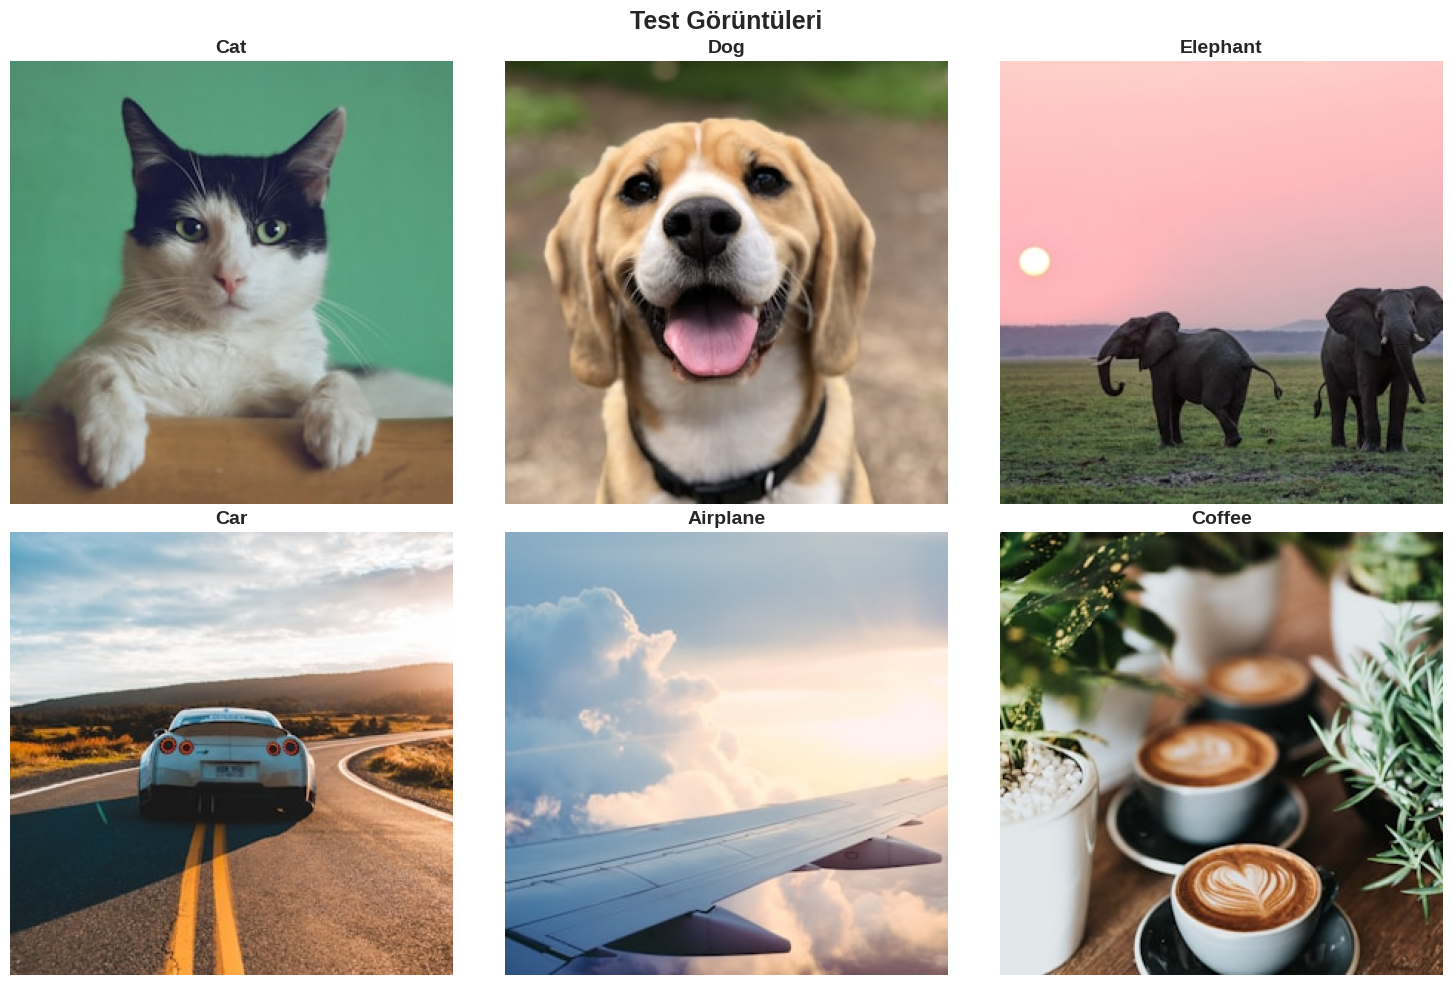

In [10]:
def load_test_image(image_choice='cat', target_size=(299, 299)):
    """
    Test görüntüsü yükle ve ön işle
    """
    image_urls = {
        'cat': 'https://images.unsplash.com/photo-1514888286974-6c03e2ca1dba?w=299&h=299&fit=crop',
        'dog': 'https://images.unsplash.com/photo-1543466835-00a7907e9de1?w=299&h=299&fit=crop',
        'elephant': 'https://images.unsplash.com/photo-1564760055775-d63b17a55c44?w=299&h=299&fit=crop',
        'car': 'https://images.unsplash.com/photo-1568605117036-5fe5e7bab0b7?w=299&h=299&fit=crop',
        'airplane': 'https://images.unsplash.com/photo-1436491865332-7a61a109cc05?w=299&h=299&fit=crop',
        'coffee': 'https://images.unsplash.com/photo-1509042239860-f550ce710b93?w=299&h=299&fit=crop'
    }

    url = image_urls.get(image_choice, image_urls['cat'])

    try:
        response = requests.get(url, timeout=10)
        img = Image.open(io.BytesIO(response.content))
        img = img.convert('RGB')
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        return np.array(img)
    except Exception as e:
        print(f"❌ Görüntü yüklenemedi: {e}")
        # Fallback
        return np.random.randint(0, 255, (target_size[0], target_size[1], 3), dtype=np.uint8)

# Birkaç test görüntüsü yükle
test_images = {}
image_choices = ['cat', 'dog', 'elephant', 'car', 'airplane', 'coffee']

print("📥 Test görüntüleri yükleniyor...\n")
for choice in image_choices:
    test_images[choice] = load_test_image(choice)
    print(f"✅ {choice.capitalize()} yüklendi")

# Görüntüleri göster
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, (name, img) in enumerate(test_images.items()):
    axes[i].imshow(img)
    axes[i].set_title(name.capitalize(), fontsize=14, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Test Görüntüleri', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.3 Inference: Xception vs Inception V3

Her iki model ile tahmin yapalım ve karşılaştıralım!


🔮 Predicting: cat...
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


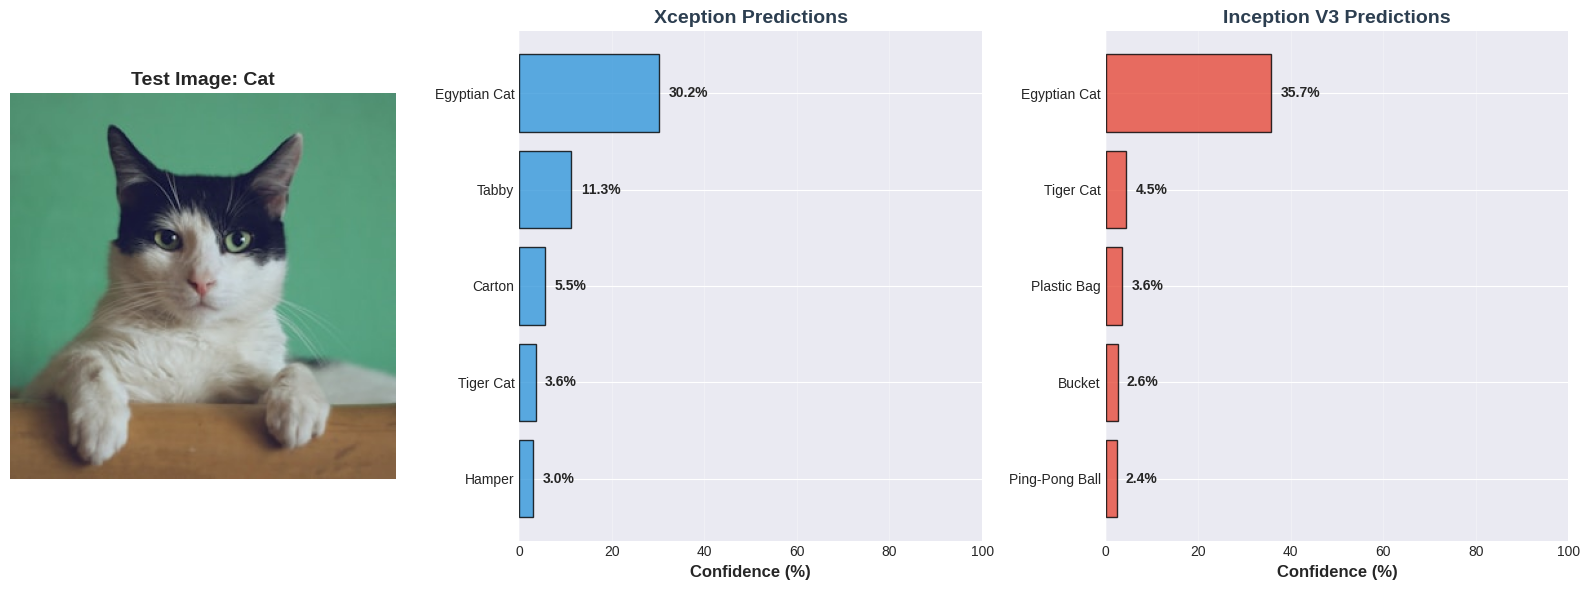


📊 TOP PREDICTIONS COMPARISON - CAT

🟦 Xception Top-1: Egyptian Cat (30.19%)
🟥 Inception Top-1: Egyptian Cat (35.74%)

✅ Both models agree on top prediction!

🔮 Predicting: dog...


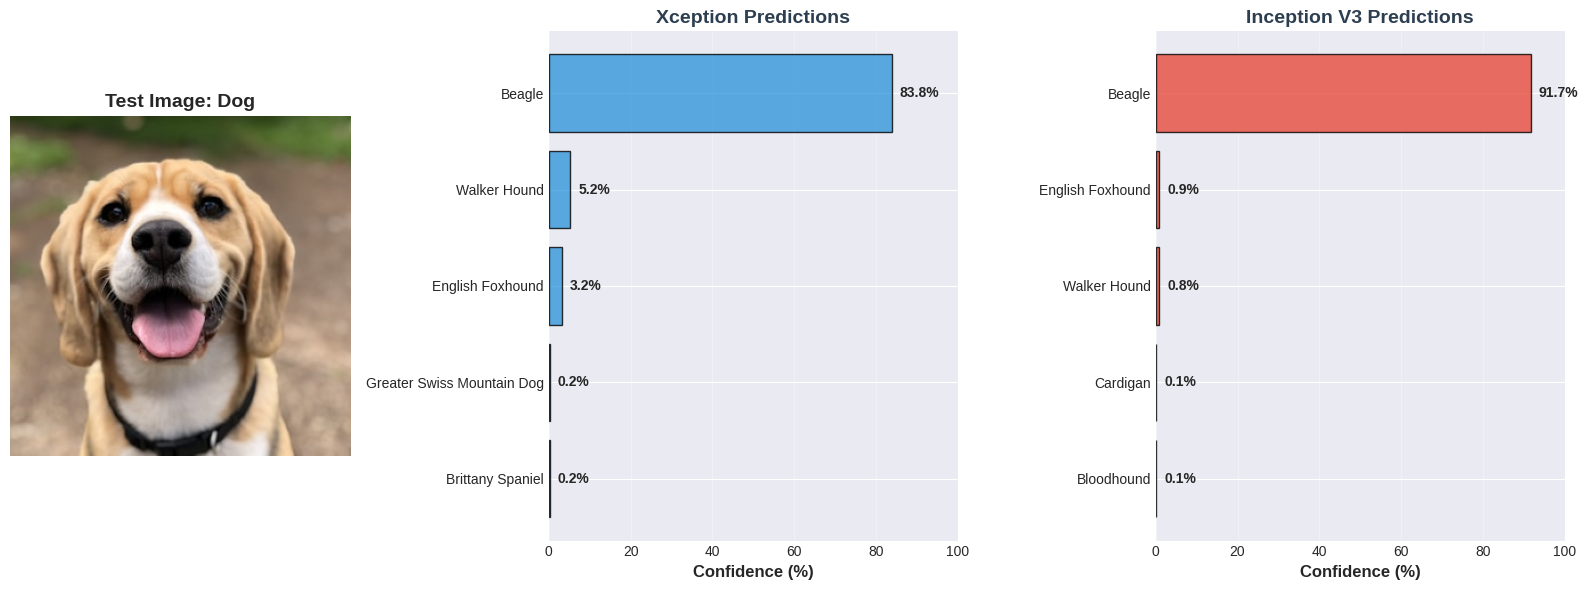


📊 TOP PREDICTIONS COMPARISON - DOG

🟦 Xception Top-1: Beagle (83.79%)
🟥 Inception Top-1: Beagle (91.68%)

✅ Both models agree on top prediction!

🔮 Predicting: elephant...


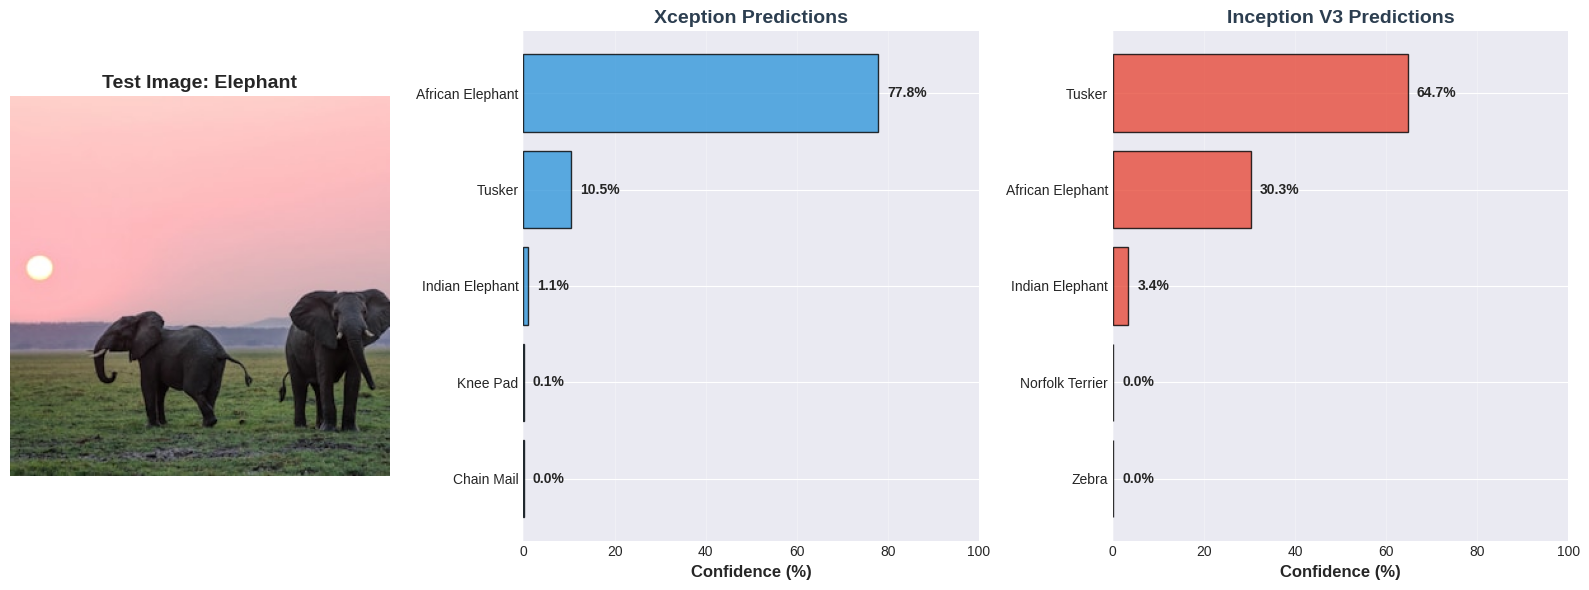


📊 TOP PREDICTIONS COMPARISON - ELEPHANT

🟦 Xception Top-1: African Elephant (77.79%)
🟥 Inception Top-1: Tusker (64.68%)

⚠️ Models disagree on top prediction!

🔮 Predicting: car...


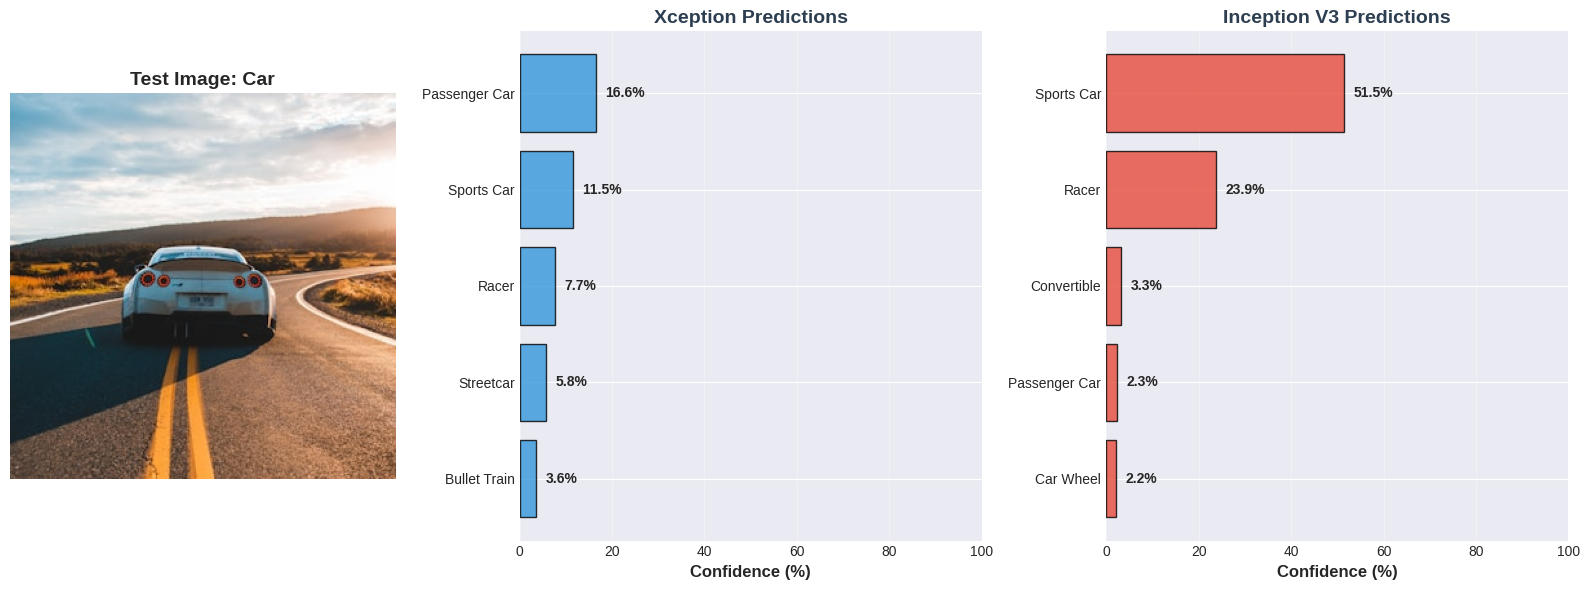


📊 TOP PREDICTIONS COMPARISON - CAR

🟦 Xception Top-1: Passenger Car (16.55%)
🟥 Inception Top-1: Sports Car (51.48%)

⚠️ Models disagree on top prediction!

🔮 Predicting: airplane...


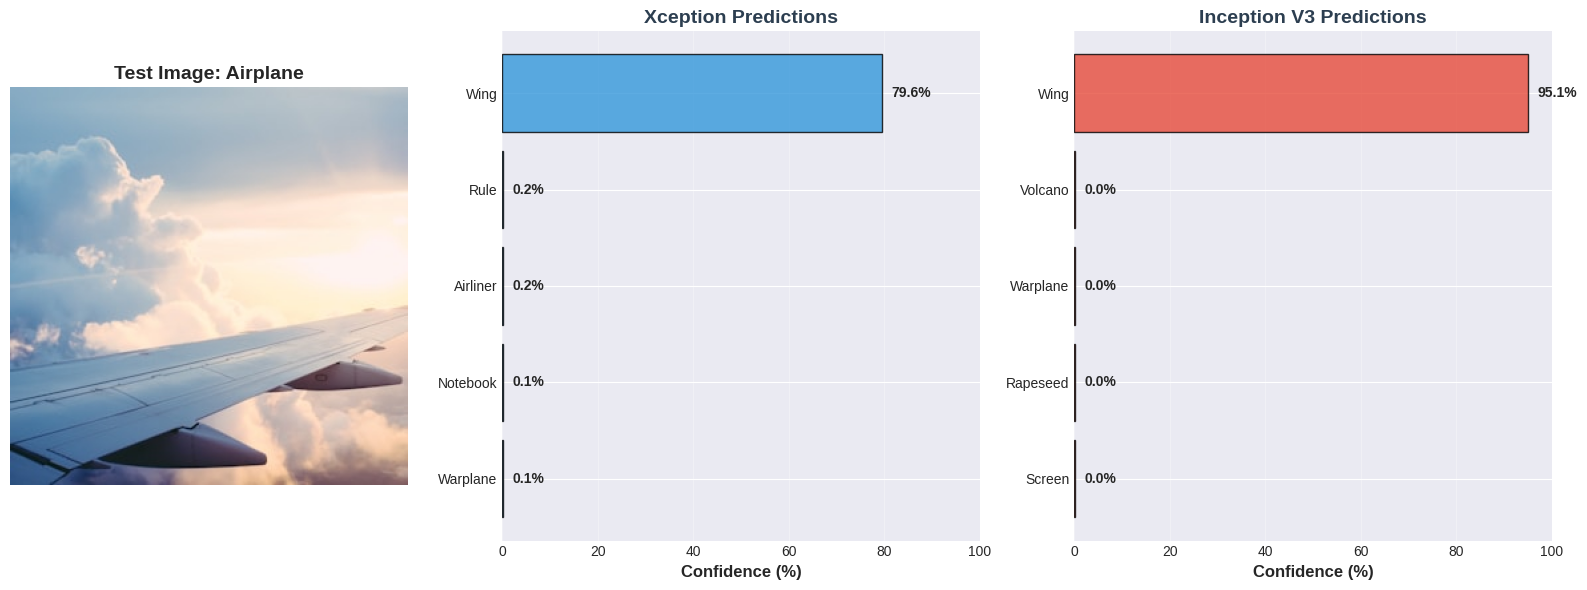


📊 TOP PREDICTIONS COMPARISON - AIRPLANE

🟦 Xception Top-1: Wing (79.59%)
🟥 Inception Top-1: Wing (95.09%)

✅ Both models agree on top prediction!

🔮 Predicting: coffee...


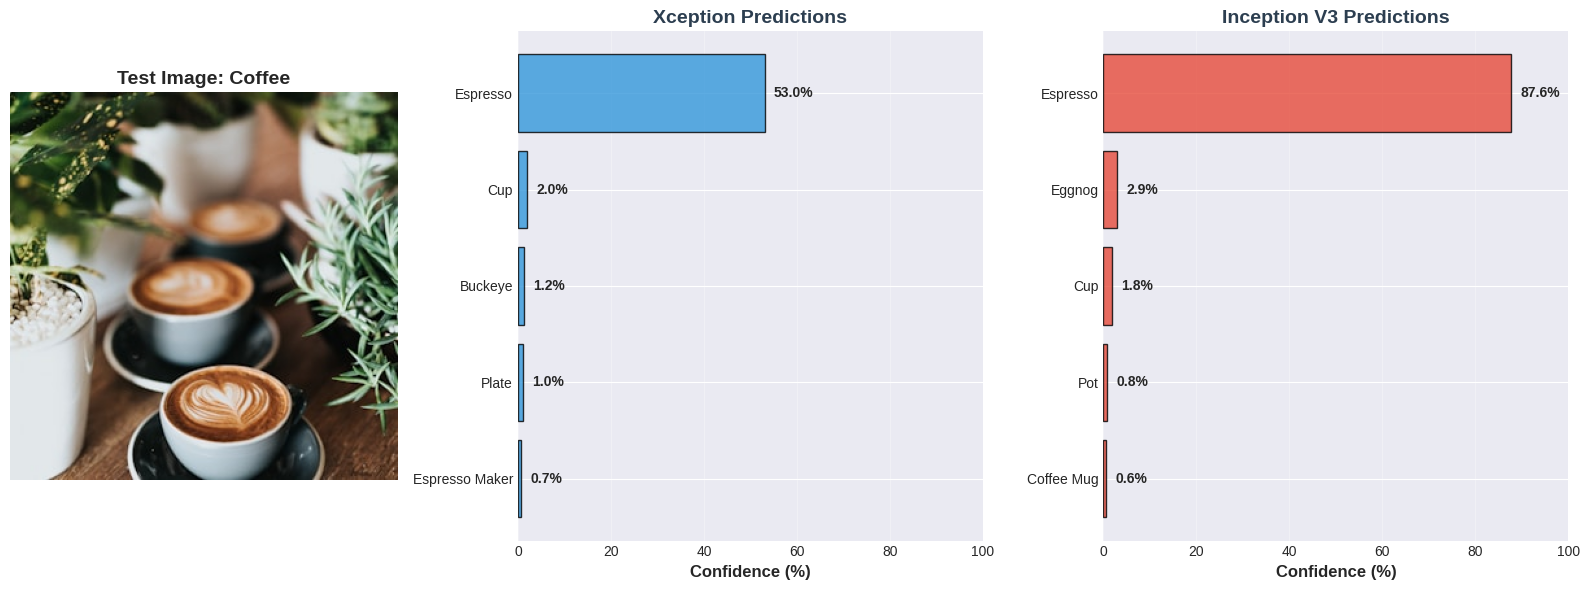


📊 TOP PREDICTIONS COMPARISON - COFFEE

🟦 Xception Top-1: Espresso (53.03%)
🟥 Inception Top-1: Espresso (87.59%)

✅ Both models agree on top prediction!


In [11]:
def predict_and_compare(image, image_name, xception_model, inception_model, top_k=5):
    """
    Her iki model ile tahmin yap ve karşılaştır
    """
    # Preprocess for each model
    img_xception = xception_preprocess(image.copy())
    img_inception = inception_preprocess(image.copy())

    # Add batch dimension
    img_xception = np.expand_dims(img_xception, axis=0)
    img_inception = np.expand_dims(img_inception, axis=0)

    # Predictions
    print(f"\n🔮 Predicting: {image_name}...")

    preds_xception = xception_model.predict(img_xception, verbose=0)
    preds_inception = inception_model.predict(img_inception, verbose=0)

    # Decode predictions
    decoded_xception = decode_predictions(preds_xception, top=top_k)[0]
    decoded_inception = decode_predictions(preds_inception, top=top_k)[0]

    # Visualize
    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1.2, 1.2])

    # Original image
    ax0 = fig.add_subplot(gs[0])
    ax0.imshow(image)
    ax0.set_title(f'Test Image: {image_name.capitalize()}',
                  fontsize=14, fontweight='bold')
    ax0.axis('off')

    # Xception predictions
    ax1 = fig.add_subplot(gs[1])
    labels_x = [pred[1].replace('_', ' ').title() for pred in decoded_xception]
    scores_x = [pred[2] * 100 for pred in decoded_xception]

    bars1 = ax1.barh(labels_x, scores_x, color='#3498db', alpha=0.8, edgecolor='black')
    ax1.set_xlabel('Confidence (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Xception Predictions', fontsize=14, fontweight='bold', color='#2c3e50')
    ax1.set_xlim(0, 100)
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)

    # Add percentage labels
    for bar, score in zip(bars1, scores_x):
        ax1.text(score + 2, bar.get_y() + bar.get_height()/2,
                f'{score:.1f}%', va='center', fontweight='bold')

    # Inception predictions
    ax2 = fig.add_subplot(gs[2])
    labels_i = [pred[1].replace('_', ' ').title() for pred in decoded_inception]
    scores_i = [pred[2] * 100 for pred in decoded_inception]

    bars2 = ax2.barh(labels_i, scores_i, color='#e74c3c', alpha=0.8, edgecolor='black')
    ax2.set_xlabel('Confidence (%)', fontsize=12, fontweight='bold')
    ax2.set_title('Inception V3 Predictions', fontsize=14, fontweight='bold', color='#2c3e50')
    ax2.set_xlim(0, 100)
    ax2.invert_yaxis()
    ax2.grid(axis='x', alpha=0.3)

    for bar, score in zip(bars2, scores_i):
        ax2.text(score + 2, bar.get_y() + bar.get_height()/2,
                f'{score:.1f}%', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print comparison
    print("\n" + "="*80)
    print(f"📊 TOP PREDICTIONS COMPARISON - {image_name.upper()}")
    print("="*80)
    print(f"\n🟦 Xception Top-1: {decoded_xception[0][1].replace('_', ' ').title()} ({decoded_xception[0][2]*100:.2f}%)")
    print(f"🟥 Inception Top-1: {decoded_inception[0][1].replace('_', ' ').title()} ({decoded_inception[0][2]*100:.2f}%)")

    if decoded_xception[0][1] == decoded_inception[0][1]:
        print("\n✅ Both models agree on top prediction!")
    else:
        print("\n⚠️ Models disagree on top prediction!")

    print("="*80)

    return decoded_xception, decoded_inception

# Test all images
for name, img in test_images.items():
    predict_and_compare(img, name, xception_model, inception_model)

## 3.4 İnteraktif Prediction

Kendi görüntünüzü yükleyin ve tahmin yapın!

In [12]:
# Kullanıcı görüntü upload edebilir
def upload_and_predict():
    """
    Kullanıcıdan görüntü al ve tahmin yap
    """
    from google.colab import files

    print("📤 Lütfen bir görüntü yükleyin (JPG, PNG)...")
    uploaded = files.upload()

    if uploaded:
        filename = list(uploaded.keys())[0]
        img = Image.open(io.BytesIO(uploaded[filename]))
        img = img.convert('RGB')
        img = img.resize((299, 299), Image.Resampling.LANCZOS)
        img_array = np.array(img)

        # Predict
        predict_and_compare(img_array, filename, xception_model, inception_model)
    else:
        print("❌ Görüntü yüklenemedi!")

print("💡 Kendi görüntünüzü test etmek için aşağıdaki hücreyi çalıştırın!")
print("Uncomment ve çalıştırın:")
print("# upload_and_predict()")

💡 Kendi görüntünüzü test etmek için aşağıdaki hücreyi çalıştırın!
Uncomment ve çalıştırın:
# upload_and_predict()


---

## 🎯 Part 2 Özeti

### Ne Öğrendik?

1. ✅ **Inception Evolution:** Canonical → Simplified → Extreme (Depthwise Separable)
2. ✅ **Xception Architecture:** Entry/Middle/Exit flow yapısı
3. ✅ **Model Comparison:** Xception vs Inception V3 detayları
4. ✅ **Real Inference:** Pre-trained model ile gerçek tahminler
5. ✅ **Performance:** Her iki model de benzer tahminler yapıyor

### Önemli Noktalar:

- Xception daha az parametre ile daha iyi performans!
- Depthwise separable convolution çok etkili!
- Residual connections convergence için kritik

### Sıradaki Part'ta:

- 🎨 **Grad-CAM:** Model neye bakıyor?
- 📊 **Feature Maps:** İç katman görselleştirme
- 📈 **Training Curves:** ImageNet ve JFT sonuçları
- 🔬 **Ablation Studies:** Residual connections, activations
- 🎓 **Sonuçlar ve Öğrendiklerimiz**

---

## 📝 Devam İçin:

**Part 3:** `xception_part3_visualization_results.ipynb`

---

**👨‍🎓 Hazırlayan:** Çağatay ÜRESİN  
**📅 Tarih:** 17 Aralık 2025  
**📧 GitHub:** [@cagatayuresin](https://github.com/cagatayuresin)